# 🪨 Stone

## 📥 라이브러리 준비

In [2]:
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# Thanks to **dhaitz**!
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# 한글폰트 설정
import matplotlib as mpl
mpl.rc('font', family='D2Coding')
mpl.rcParams['axes.unicode_minus'] = False

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 🗂️ 데이터셋 준비

### 🤔 데이터셋을 준비하는 방법

In [72]:
# 이미지 데이터가 있는 디렉토리와 데이터 세트 분할 비율(train_ratio)을 정한다.
dataset_dir = 'dataset'
train_ratio = 0.8   # 전체 데이터 중 훈련 데이터의 비중이 0.8이라는 의미이다.

#### 🧶 데이터 변환 정의

In [73]:
# 이미지 데이터를 ResNet50에서 다룰 수 있도록 변환시키는 방법을 정한다. (resnet50_transform)
resnet50_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize(224),
    transforms.ToTensor()
])
# convert image size to 224x224 for ResNet50 after crop

# 설정한 이미지 데이터 변환 방법을 출력하여 확인한다.
resnet50_transform

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

#### 📂 데이터 불러오기

In [74]:
# datasets.ImageFolder를 사용해서 학습 데이터(stone_dataset)를 만든다.
# 이전에 정의한 데이터 변환이 적용된다. 
dataset = datasets.ImageFolder(dataset_dir, transform=resnet50_transform)

# 데이터의 형식을 확인한다.
dataset

Dataset ImageFolder
    Number of datapoints: 155
    Root location: dataset
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

#### 🎰 인덱스 셔플

In [75]:
# train_data 사이즈만큼의 정수값을 갖는 인덱스 리스트(indices)를 만들고 확인한다.
dataset_size = len(dataset)
indices = np.arange(dataset_size)
display(indices)

# 인덱스 리스트를 랜덤하게 섞고 확인한다.
np.random.shuffle(indices)
indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154])

array([  6, 139,  94,  65,  14,   2,   5,  59,  58,  41, 103,  50, 109,
         4, 117,  36,  78, 101,   7,  37,  57, 142, 132,   3,  71, 154,
        30,  99,  16, 112, 113,  70,  35,  33,  13,  80,  43, 118,  67,
        56,  86,  46,  44,  95,  15,  45,  18,  85, 141,  40, 138,  19,
       130,   9, 129,  51, 146,  79,  47,  92,  29,  20,  89, 134,   0,
         1, 147, 115,  27,  90,  87,  22,  97,  25,  32,  63,  88, 137,
        64,  42,  68,  81, 148,  39,  34, 119, 108, 104, 125,  60,  93,
        17,  53, 145,  31, 120,  98,  12,  66,  72,  10, 136, 100,  74,
        77, 135, 128, 140,  73, 124,  48, 106,  26, 152,  61,  96, 133,
       114, 153,  76, 122,  28, 121,  84,  49, 102,  82, 111, 150,  38,
        23, 127,  69, 123, 149, 151,  21, 110,  55,  62,  11, 105,   8,
       143, 126,  54, 131,  83,  52, 144, 116,  24, 107,  91,  75])

#### ✂️ 인덱스 분할

In [76]:
# 분할 비율(train_size)에 해당하는 인덱스를 계산하고 확인해 본다.
train_size = int(dataset_size * train_ratio)
test_size = dataset_size - train_size
print(f'{train_size=} {test_size=}')

# 학습 데이터 인덱스 리스트 및 테스트 인덱스 리스트를 만들고 확인해 본다.
train_indices, test_indices = indices[:train_size], indices[train_size:]
train_indices, test_indices

train_size=124 test_size=31


(array([  6, 139,  94,  65,  14,   2,   5,  59,  58,  41, 103,  50, 109,
          4, 117,  36,  78, 101,   7,  37,  57, 142, 132,   3,  71, 154,
         30,  99,  16, 112, 113,  70,  35,  33,  13,  80,  43, 118,  67,
         56,  86,  46,  44,  95,  15,  45,  18,  85, 141,  40, 138,  19,
        130,   9, 129,  51, 146,  79,  47,  92,  29,  20,  89, 134,   0,
          1, 147, 115,  27,  90,  87,  22,  97,  25,  32,  63,  88, 137,
         64,  42,  68,  81, 148,  39,  34, 119, 108, 104, 125,  60,  93,
         17,  53, 145,  31, 120,  98,  12,  66,  72,  10, 136, 100,  74,
         77, 135, 128, 140,  73, 124,  48, 106,  26, 152,  61,  96, 133,
        114, 153,  76, 122,  28, 121,  84]),
 array([ 49, 102,  82, 111, 150,  38,  23, 127,  69, 123, 149, 151,  21,
        110,  55,  62,  11, 105,   8, 143, 126,  54, 131,  83,  52, 144,
        116,  24, 107,  91,  75]))

#### ♒ 데이터 샘플러와 데이터 로더 정의

In [77]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# 데이터 샘플링 방식(SubsetRandomSampler)을 지정한다.
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# 데이터 로더를 만든다. (sampler, 배치 크기를 지정할 수 있음)
train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=16)
test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=16)

#### 📦 하나의 함수로 정리

In [78]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# 위의 코드들을 묶어서 load_split_train_test() 함수를 만든다. (입력 : 데이터 디렉토리, 분할 비율) (출력 : 학습 데이터 로더, 테스트 데이터 로더)
def load_split_train_test(dataset_dir: str, train_ratio: float):
    resnet50_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor()
    ])
    
    dataset = datasets.ImageFolder(dataset_dir, transform=resnet50_transform)

    dataset_size = len(dataset)
    indices = np.arange(dataset_size)
    np.random.shuffle(indices)

    train_size = int(dataset_size * train_ratio)
    train_indices, test_indices = indices[:train_size], indices[train_size:]
    
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=16)
    test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=16)
    
    return train_loader, test_loader

### 📚 데이터 로더 생성

In [80]:
dataset_dir = 'dataset'
train_ratio = 0.8

train_loader, test_loader = load_split_train_test(dataset_dir, train_ratio)

## 이미지 데이터 샘플들을 살펴본다.

### 임의의 데이터를 로딩한 후 이미지와 레이블을 반환하는 get_random_images() 함수를 만든다.

### 임의 선택한 이미지를 표시해 본다.

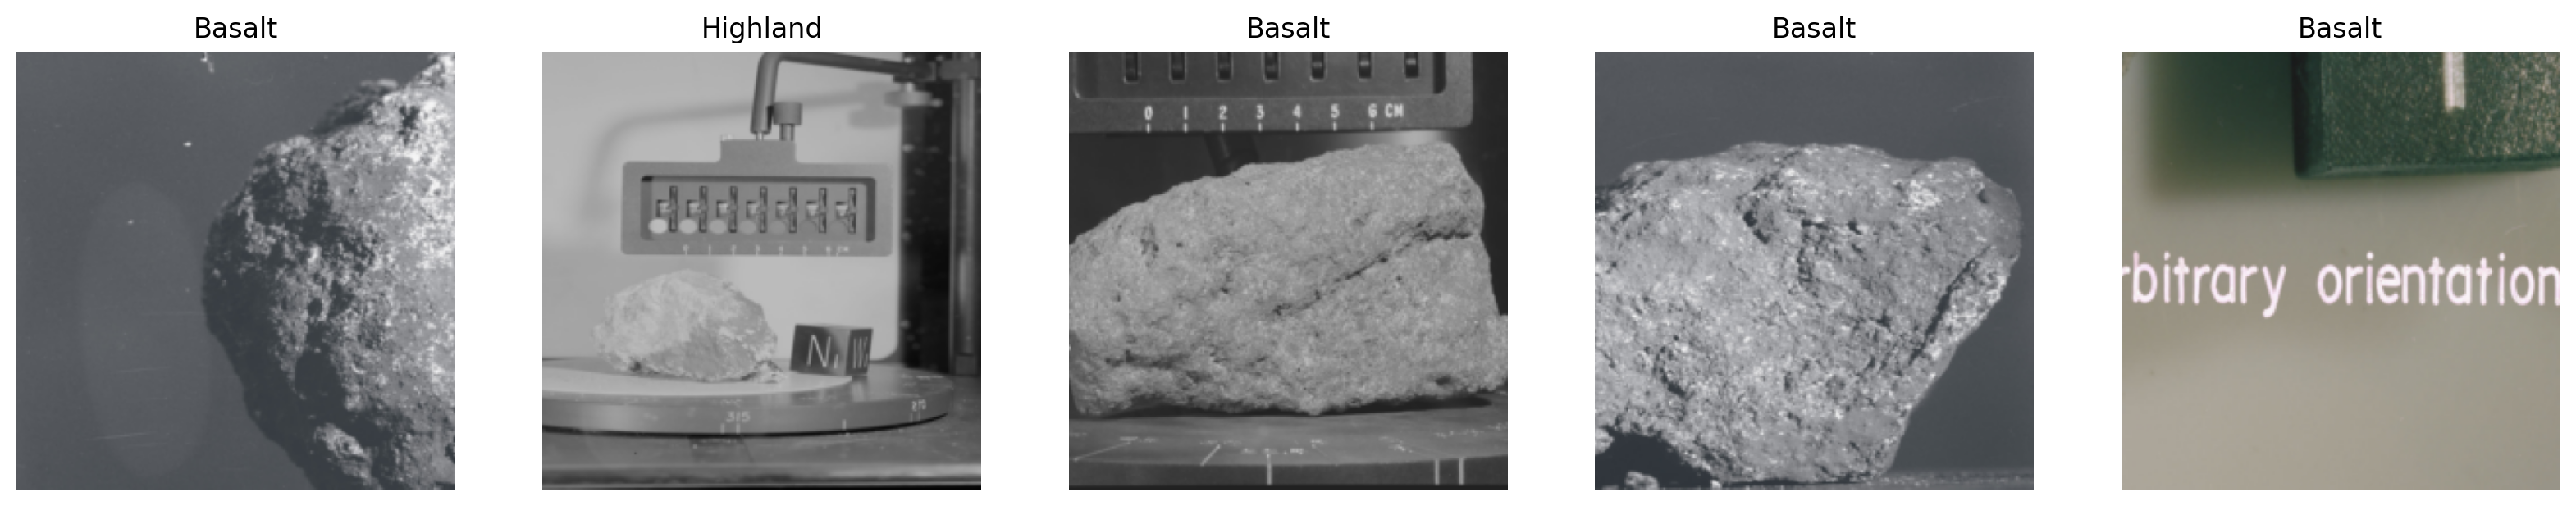

In [12]:
# 5개의 이미지와 레이블을 랜덤하게 가져온다.

# 픽셀 배열을 PIL 형식의 이미지로 변환하고 이미지 크기를 지정한다.


# 학습 데이터의 class 리스트를 얻는다.


# 이미지를 표시하기 위한 설정을 한다.


# 주피터 노트북에 이미지를 표시한다.


# ResNet50 모델을 가져와 FCL(Fully Connected Layer)을 수정한다.

## Compute device를 정한다(CPU or GPU)

In [13]:
# compute device를 정하고 확인한다.


cpu


## 사전학습된 ResNet50 모델을 지정한다.

In [14]:
# resnet50 모델을 pretrained=True로 설정한다.


/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### (확인) 수정 전의 ResNet50 모델을 확인해 본다. 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## FCL을 수정한다.(뉴런 구축, 신경망 연결, FCL의 layer 설정 등)

In [16]:
# 모든 신경망 구축 : 전이학습을 위해 모델의 가중치를 freeze 한다.
    
# 뉴런들을 연결하여 신경망을 생성한다.


# q: explain the above code
# a: 2048개의 입력을 받아 512개의 출력을 내고, ReLU 함수를 거쳐 0.2의 확률로 Dropout을 적용한다.
# 512개의 입력을 받아 2개의 출력을 내고, LogSoftmax 함수를 거쳐 1차원으로 변환한다.
# 1차원으로 변환된 출력을 갖는 신경망을 생성한다.

# 손실함수를 Cross entropy loss 함수로 지정한다.

# why
# optimizer를 Adam으로 지정한다.
# what is Adam
#

# 신경망을 compute device로 보낸다.

# 종료 여부를 출력한다.



done!


### (확인) FCL을 확인해 본다.

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)


# 모델의 FCL을 학습시키고 테스트 한다.

## 모델 학습/검증을 위한 변수를 설정한다.

In [18]:
# 에폭 및 출력 간격을 설정한다.

# 손실 변수들을 초기화 한다.

# 현재의 학습 단계를 표현하는 steps 변수를 0으로 초기화 한다.



## 설정한 에폭만큼 모델을 학습시키며 검증/평가 한다.

In [19]:
# 설정한 회수만큼 학습 후 테스트 및 평가해 본다.


Training step  1
Training step  2
Training step  3
Training step  4
Training step  5
Epoch 1/10:  Train loss: 3.523..  Test loss: 0.896..  Test accuracy: 0.450

Training step  6
Training step  7
Training step  8
Training step  9
Training step  10
Epoch 2/10:  Train loss: 0.944..  Test loss: 0.938..  Test accuracy: 0.554

Training step  11
Training step  12
Training step  13
Training step  14
Training step  15
Epoch 3/10:  Train loss: 0.975..  Test loss: 0.776..  Test accuracy: 0.454

Training step  16
Training step  17
Training step  18
Training step  19
Training step  20
Epoch 4/10:  Train loss: 0.656..  Test loss: 0.566..  Test accuracy: 0.710

Training step  21
Training step  22
Training step  23
Training step  24
Training step  25
Epoch 5/10:  Train loss: 0.639..  Test loss: 0.507..  Test accuracy: 0.773

Training step  26
Training step  27
Training step  28
Training step  29
Training step  30
Epoch 6/10:  Train loss: 0.342..  Test loss: 0.431..  Test accuracy: 0.804

Training step

### (확인) 학습 손실값과 테스트 손실값을 그래프로 확인한다.

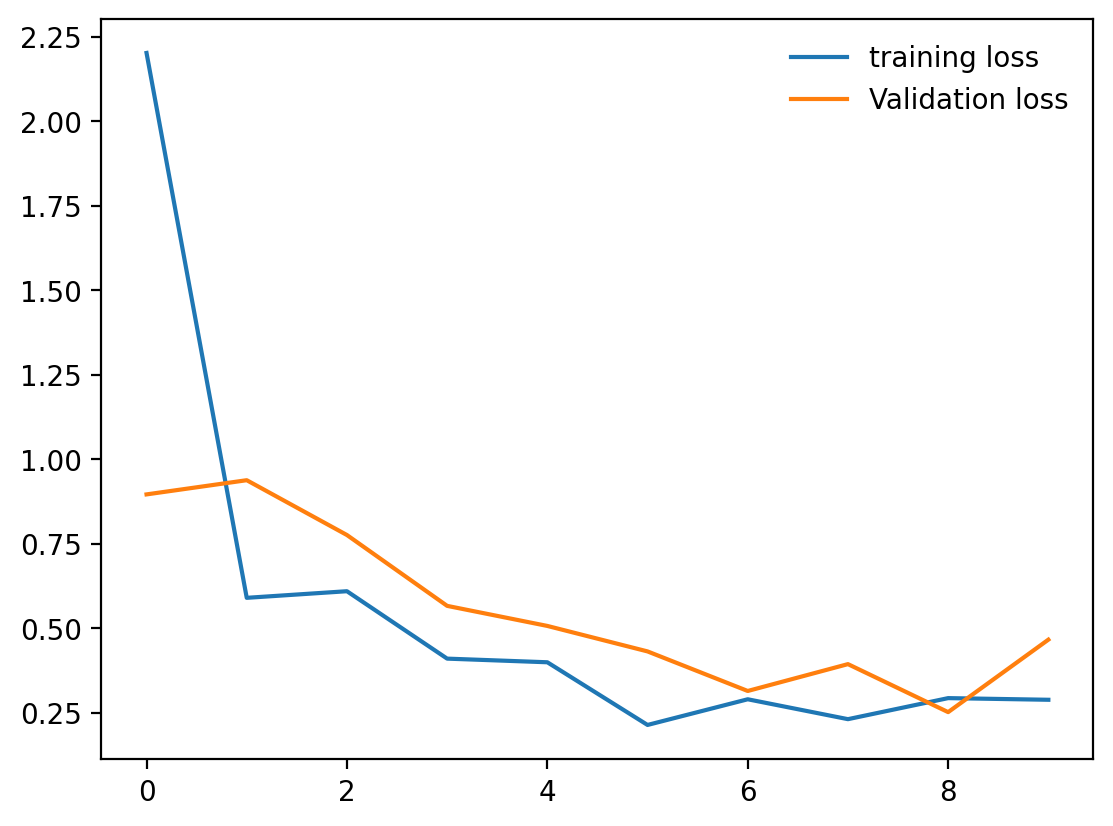

In [20]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# in this graph, what is x-axis? y-axis?
# x-axis: epoch
# y-axis: loss

# 학습/테스트 완료된 모델을 저장한다.

In [21]:
# 추후 로드하여 사용할 수 있도록 학습/테스트 완료된 모델을 저장한다.


# 완성된 모델을 사용하여 예측한다.

## 저장한 모델을 불러온다.

In [22]:
# 저장한 모델을 불러온다.


### (확인) 불러온 모델을 확인해 본다.

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 이미지 예측을 위해 predict_image() 함수를 만든다.

## 5개의 이미지를 임의로 가져와 예측해 본다.

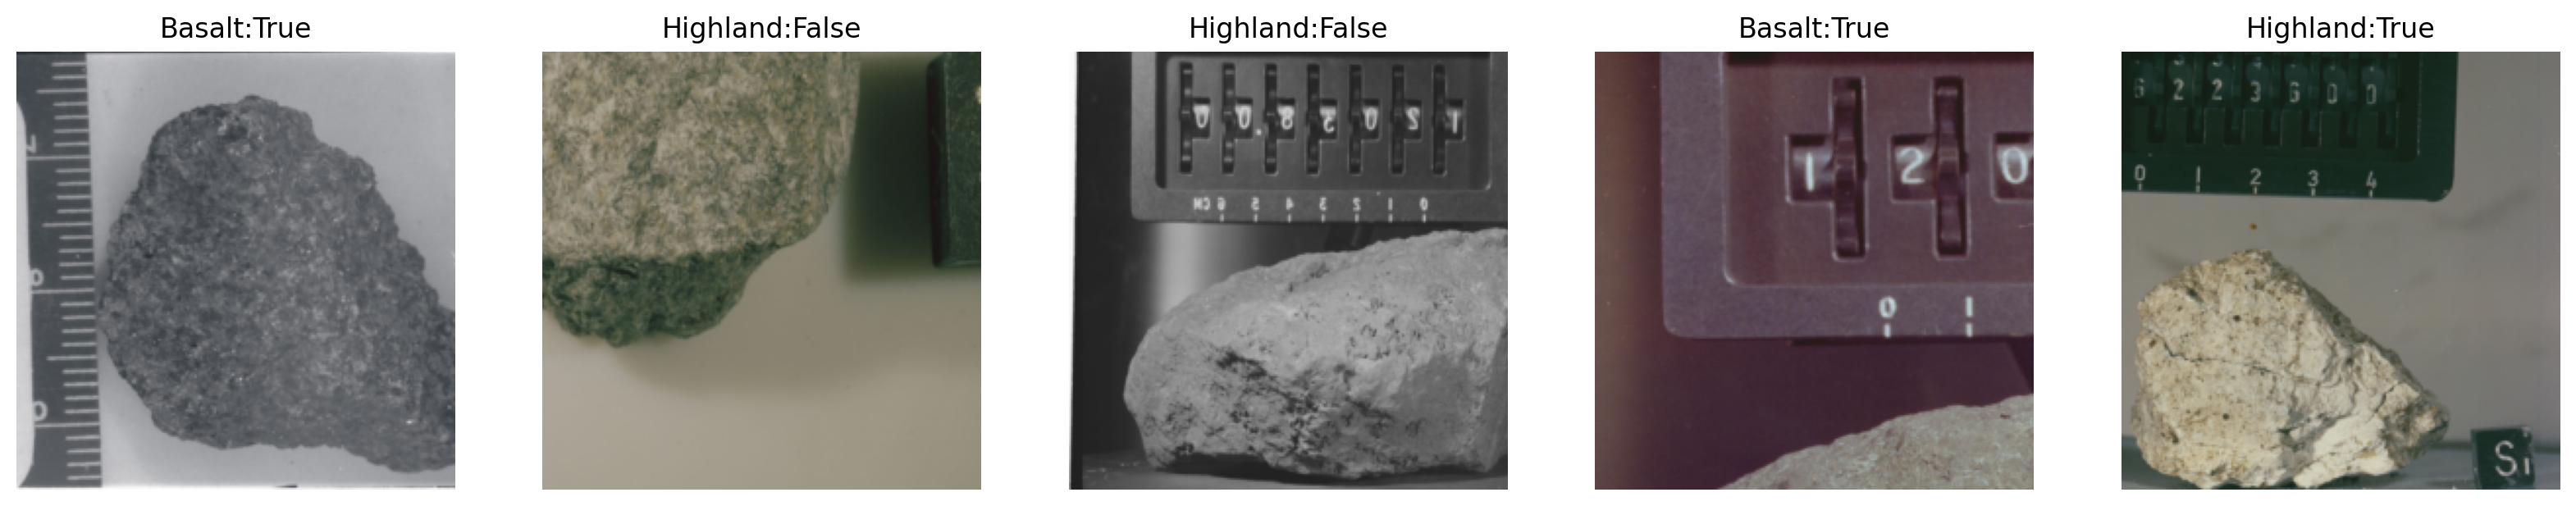